In [11]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from pathlib import Path
!pip install pandas_path
from pandas_path import path

!pip install rasterio
import rasterio

import cv2
import albumentations
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [12]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Following the tutorial at https://www.depends-on-the-definition.com/unet-keras-segmenting-images/

## Load the training dataframe

In [30]:
img_size = 512

In [14]:
# This is where our downloaded images and metadata live locally
#DATA_PATH = Path.cwd().parent / "runtime" / "data" / "train_features"
DATA_PATH = Path.cwd().parent / "content" / "drive" / "MyDrive" / "DATA SCIENCE" / "data google colab" / "floodwater" / "train_features"
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

In [15]:
#adding the path to the images and labels in the dataframe
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path
)

train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

In [16]:
train_metadata['feature_path'][0]

'/content/drive/MyDrive/DATA SCIENCE/data google colab/floodwater/train_features/train_features/awc00_vh.tif'

## Split the training data into train and test

In [17]:
random.seed(0)  # set a seed for reproducibility

# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['kuo', 'wvy', 'awc']

In [18]:
test = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [19]:
def get_paths_by_chip(image_level_df):
    """
    Function that take as input the meta_dataframe
    and return a dataframe with the chip id and both path for vv and vh.
    """
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        paths.append([chip, vv_path, vh_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path"])

In [20]:
# Separate features from labels
test_meta_x = get_paths_by_chip(test)
test_meta_y = test[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_meta_x = get_paths_by_chip(train)
train_meta_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

## Get the images from the train and test metadata

In [64]:
def numpy_mask(image_path):
    with rasterio.open(image_path) as img:
        metadata = img.meta
        bounds = img.bounds
        data = img.read(1)  # read a single band

    with rasterio.open(image_path) as img:
        return img.read(1, masked=True)

In [65]:
def get_images(df):
    images = []
    
    #features
    if df.shape[1] == 3:
        for row in df.index:
            with rasterio.open(df.iloc[row].vv_path) as vv:
                vv_img = vv.read(1)
            with rasterio.open(df.iloc[row].vh_path) as vh:
                vh_img = vh.read(1)
            img = np.stack([vv_img, vh_img], axis=-1)
       
            # Min-max normalization
            #min_norm = -77
            #max_norm = 26
            #img = np.clip(img, min_norm, max_norm)
            #img = (img - min_norm) / (max_norm - min_norm)
            
            #img = np.transpose(img, [2, 0, 1])
                
            images.append(img)
        
    #labels
    if df.shape[1] == 2:
        for path in df['label_path'].to_list():
            with rasterio.open(path) as lp:
                img = lp.read(1)
      
            images.append(img)
            
    return images

In [66]:
train_x = np.array(get_images(train_meta_x))
train_y = np.array(get_images(train_meta_y))
test_x = np.array(get_images(test_meta_x))
test_y = np.array(get_images(test_meta_y))

In [80]:
train_x.shape

(430, 512, 512, 2)

## Image augmentation

In [101]:
random.seed(0)

transform = albumentations.Compose(
    [
        #albumentations.RandomCrop(256, 256),
        albumentations.RandomRotate90(p=1),
        #albumentations.HorizontalFlip(),
        #albumentations.VerticalFlip(),
    ]
)

In [106]:
transform.transforms

In [102]:
train_x_aug = []
train_y_aug = []
for i in range(len(train_x)):
  t = transform(image=train_x[i], mask=train_y[i])
  train_x_aug.append(t['image'])
  train_y_aug.append(t['mask'])

train_x_aug = np.array(train_x_aug)
train_y_aug = np.array(train_y_aug)

In [103]:
train_x_aug.shape

(430, 512, 512, 2)

## Display the images

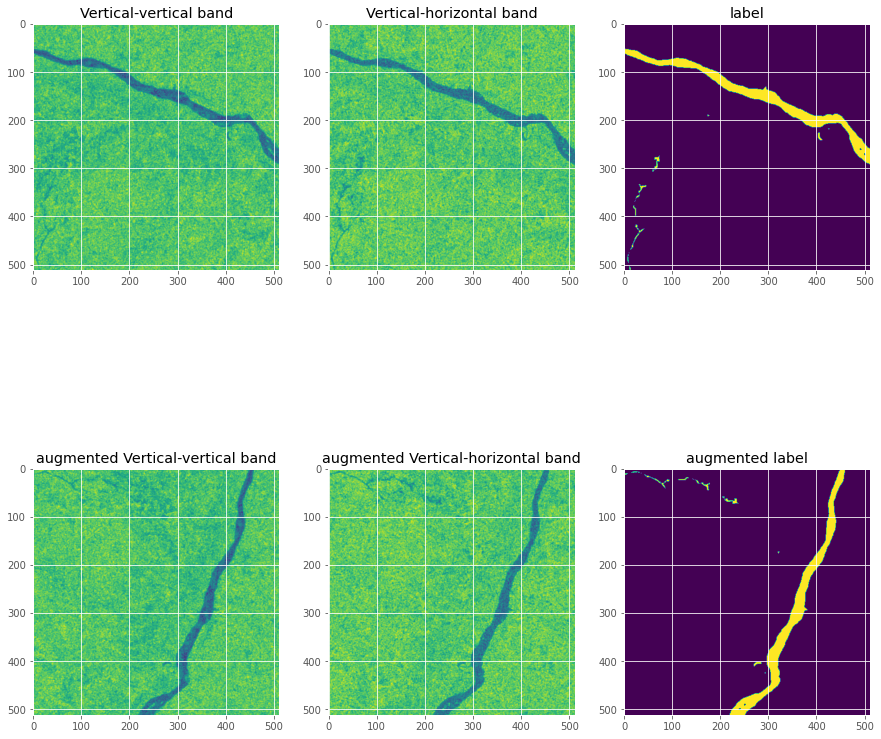

In [104]:
f, ax = plt.subplots(2, 3, figsize=(15, 15))

id = 0
#visualize radar image
ax[0][0].imshow(train_x[id, :, :, 0])
ax[0][0].set_title("Vertical-vertical band")

ax[0][1].imshow(train_x[id, :, :, 1])
ax[0][1].set_title("Vertical-horizontal band")

ax[0][2].imshow(train_y[id])
ax[0][2].set_title("label")

ax[1][0].imshow(train_x_aug[id, :, :, 0])
ax[1][0].set_title("augmented Vertical-vertical band")

ax[1][1].imshow(train_x_aug[id, :, :, 1])
ax[1][1].set_title("augmented Vertical-horizontal band")

ax[1][2].imshow(train_y_aug[id])
ax[1][2].set_title("augmented label")

plt.show()

# Unet model

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [ ]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(train_x, train_y, batch_size=16, epochs=100, callbacks=callbacks,
                    validation_data=(test_x, test_y))

Epoch 1/100
27/27 [==============================] - 67s 1s/step - loss: -43.4051 - accuracy: 0.4864 - val_loss: -105.4967 - val_accuracy: 0.2613

Epoch 00001: val_loss improved from inf to -105.49665, saving model to model-tgs-salt.h5
Epoch 2/100
27/27 [==============================] - 23s 846ms/step - loss: -57.4839 - accuracy: 0.7282 - val_loss: -106.3025 - val_accuracy: 0.2652

Epoch 00002: val_loss improved from -105.49665 to -106.30251, saving model to model-tgs-salt.h5
Epoch 3/100
27/27 [==============================] - 21s 794ms/step - loss: -57.2938 - accuracy: 0.7397 - val_loss: -114.5954 - val_accuracy: 0.2813

Epoch 00003: val_loss improved from -106.30251 to -114.59542, saving model to model-tgs-salt.h5
Epoch 4/100
27/27 [==============================] - 21s 783ms/step - loss: -60.0789 - accuracy: 0.8046 - val_loss: -25.8910 - val_accuracy: 0.4131

Epoch 00004: val_loss did not improve from -114.59542
Epoch 5/100
27/27 [==============================] - 21s 782ms/step -

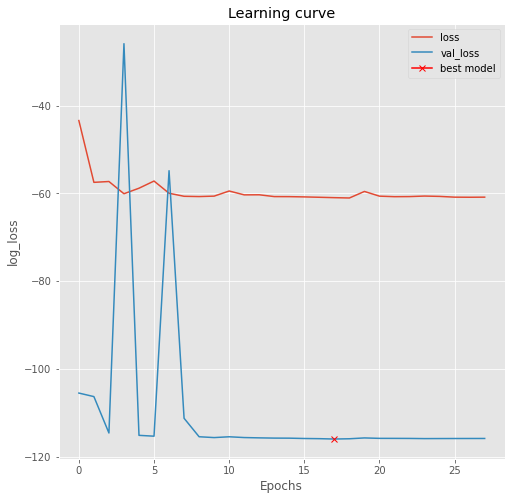

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# Load best model
model.load_weights('model-tgs-salt.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(test_x, test_y, verbose=1)

4/4 [==============================] - 7s 334ms/step - loss: -115.9705 - accuracy: 0.9206


[-115.97045135498047, 0.920569121837616]

## Predict output

In [ ]:
# Predict on train, val and test
preds_train = model.predict(train_x, verbose=1)
preds_val = model.predict(test_x, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

4/4 [==============================] - 1s 396ms/step


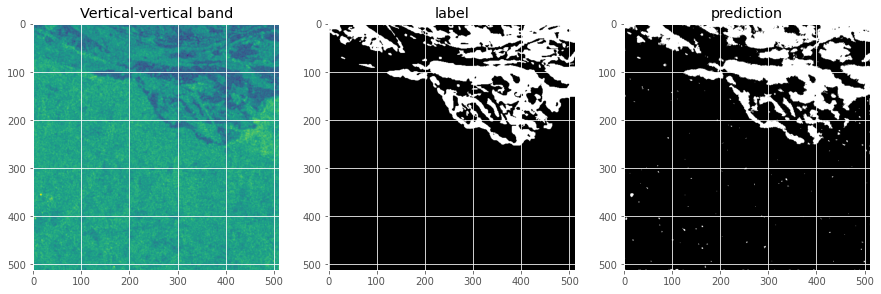

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(15, 15))

id = 12

#visualize radar image   x[:, :, 0]
ax[0].imshow(train_x[id][:, :, 0])
ax[0].set_title("Vertical-vertical band")

label = train_y[id]
label[label == 255] = 1
ax[1].imshow(label, "gray")
ax[1].set_title("label")

pred = preds_train_t[id][:, :, 0]
ax[2].imshow(pred, "gray")
ax[2].set_title("prediction")

plt.show()